# 3. Análise de componentes de Séries Temporais

Equipamento **10.115.17.226**

## Preparando a caixa de ferramentas 🧰

In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt, dates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from joblib import dump

# Defining folders
raw_data_folder = Path.cwd().resolve().parent.joinpath("data", "raw")
processed_data_folder = Path.cwd().resolve().parent.joinpath("data", "processed")
models_folder = Path.cwd().resolve().parent.joinpath("models")

#### Carregando dados

In [12]:
ip = "10.115.17.226"
measures = ("HeliumLevel", "BoreTemperature")

df_origin = pd.read_csv(
    filepath_or_buffer=processed_data_folder.joinpath(f"{ip}.csv"), 
    index_col=0, 
    parse_dates=True
)

Esse equipamento tem medições duplicadas nos dois primeiros dias (horário muito próximo e mesmo valor) e 2 medições no último dia. As medições não se alteram no período intra-dia.

Uma técnica de resampling será aplicada para padronizar os dados em períodos de 6h.

A regra de negócio influencia a aplicabilidade dessa técnica (Porque esse comportamento diferente para esse equipamento? O momento exato da medição é relevante? Como funciona a medição) e pode ser investigada mais a fundo.

In [13]:
df = df_origin.resample(rule="6h").mean().interpolate()

#### Sazonalidade, tendência e resíduos

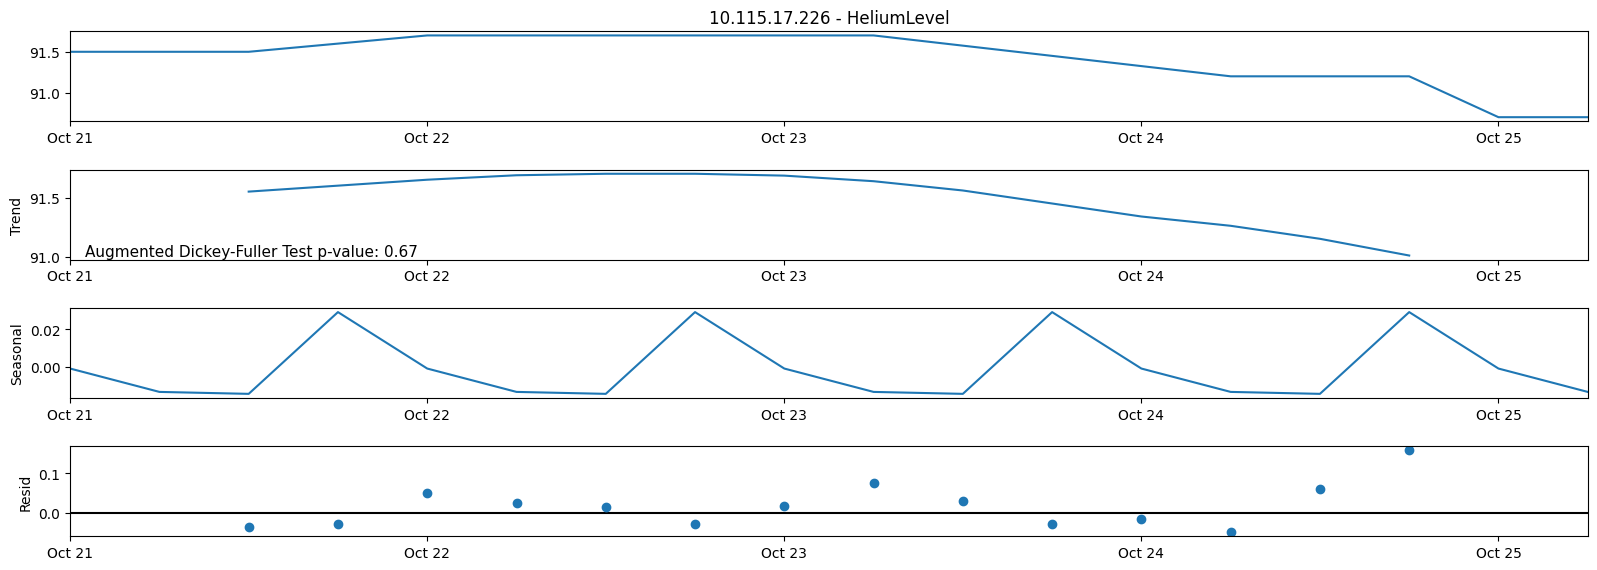

In [14]:
fig_helium = seasonal_decompose(
    df[measures[0]], 
    model="additive",  # From EDA visualization
    period=4 # 6h frequency and 4 periods for a day
).plot()
fig_helium.set_size_inches(18, 6)
fig_helium.axes[0].set_title(f"{df.index.name} - {measures[0]}")
for ax in fig_helium.axes:
    ax.xaxis.set_major_locator(dates.DayLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter("%b %d"))
fig_helium.axes[1].text(
        x=0.01, 
        y=0.01, 
        s=f"Augmented Dickey-Fuller Test p-value: {adfuller(df[measures[0]])[1]:.2f}", 
        ha="left", 
        va="bottom",
        fontsize=11,
        transform=fig_helium.axes[1].transAxes
    )
helium_adfuler_pval = adfuller(df[measures[0]])[1]
bore_adfuler_pval = adfuller(df[measures[1]])[1]
plt.show()

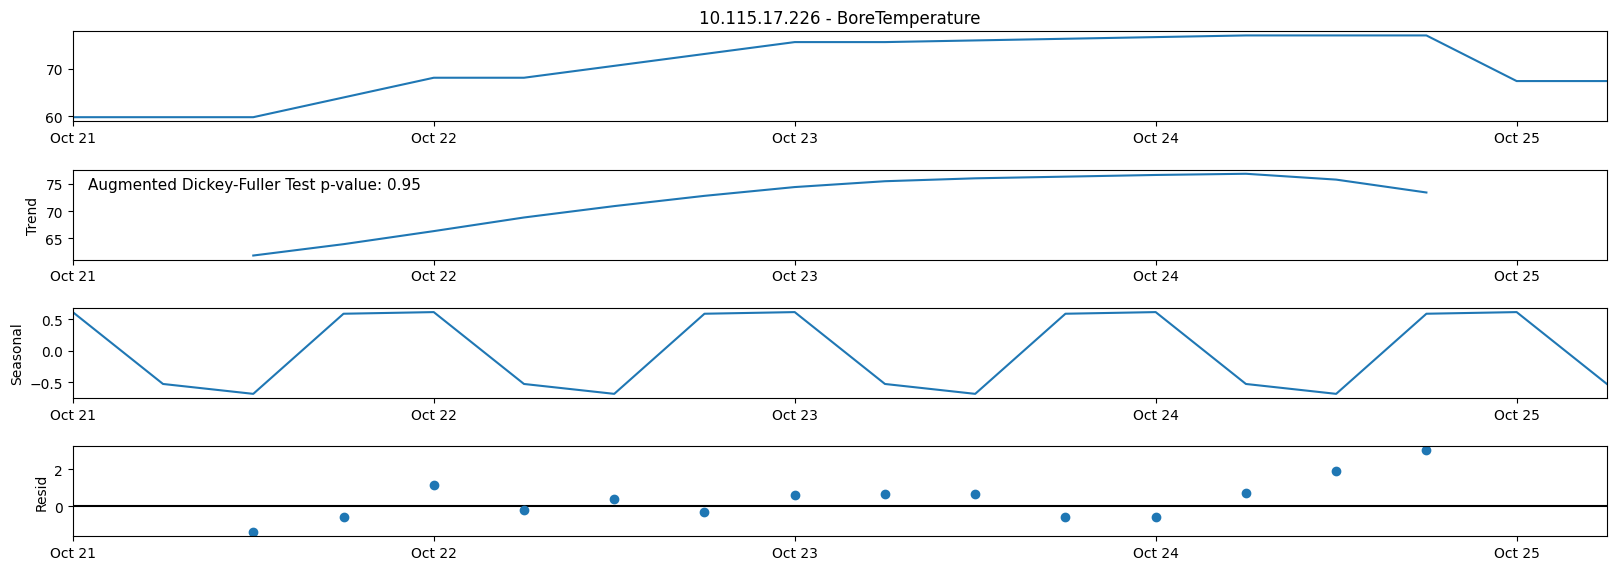

In [15]:
fig_bore = seasonal_decompose(
    df[measures[1]], 
    model="additive",  # From EDA visualization
    period=4  # 6h frequency and 4 periods for a day
).plot()
fig_bore.set_size_inches(18, 6)
fig_bore.axes[0].set_title(f"{df.index.name} - {measures[1]}")
for ax in fig_bore.axes:
    ax.xaxis.set_major_locator(dates.DayLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter("%b %d"))
fig_bore.axes[1].text(
        x=0.01, 
        y=0.92, 
        s=f"Augmented Dickey-Fuller Test p-value: {adfuller(df[measures[1]])[1]:.2f}", 
        ha="left", 
        va="top",
        fontsize=11,
        transform=fig_bore.axes[1].transAxes
    )
plt.show()

# 4. Criação dos Modelos e Predição dos dados

Divisão:
- Treino: primeiros 4 dias e meio.
- Teste: últimas 24h.

Métrica de avaliação dos modelos: 
- Menor RMSE (Root Mean Squared Error).

In [16]:
# Splitting dataset
df_train = df.iloc[:-4]
df_test = df.iloc[-4:]

# Function to plot the 
def plot_predictions(
    ip, 
    df_train, 
    df_test, 
    model, 
    measures, 
    helium_predictions, 
    helium_metrics,
    bore_predictions, 
    bore_metrics,
):
    """Function to plot the time series train, test and predictions values and print error metrics in the plot"""
    fig_hw, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    fig_hw.suptitle(f"{ip}")
    fig_hw.tight_layout()
    axes[0].set_title(f"{measures[0]}")
    axes[0].xaxis.label.set_visible(False)
    df_train[measures[0]].plot(legend=True, label="Train", marker=".",ax=axes[0])
    ## Concatenating time series just to keep the lines connected
    pd.concat([df_train[measures[0]].last("6H"), df_test[measures[0]]]).plot(legend=True, label="Test", marker=".", ax=axes[0])
    pd.concat([df_train[measures[0]].last("6H"), helium_predictions]).plot(legend=True, label="Pred", marker=".", ax=axes[0])
    axes[0].text(
        x=0.01, 
        y=0.02, 
        s=f"{model}\nMAPE: {helium_metrics[0]*100:.2f}\nRMSE: {helium_metrics[1]:.2f}", 
        ha="left", 
        va="bottom",
        fontsize=11,
        transform=axes[0].transAxes
    )
    axes[1].set_title(f"{measures[1]}")
    axes[1].xaxis.label.set_visible(False)
    df_train[measures[1]].plot(legend=True, label="Train", marker=".",ax=axes[1])
    ## Concatenating time series just to keep the lines connected
    pd.concat([df_train[measures[1]].last("6H"), df_test[measures[1]]]).plot(legend=True, label="Test", marker=".", ax=axes[1])
    pd.concat([df_train[measures[1]].last("6H"), bore_predictions]).plot(legend=True, label="Pred", marker=".", ax=axes[1])
    axes[1].text(
        x=0.99, 
        y=0.02, 
        s=f"{model}\nMAPE: {bore_metrics[0]*100:.2f}\nRMSE: {bore_metrics[1]:.2f}", 
        ha="right", 
        va="bottom",
        fontsize=11,
        transform=axes[1].transAxes
    )
    plt.show()

#### 4.1 Holt-Winters

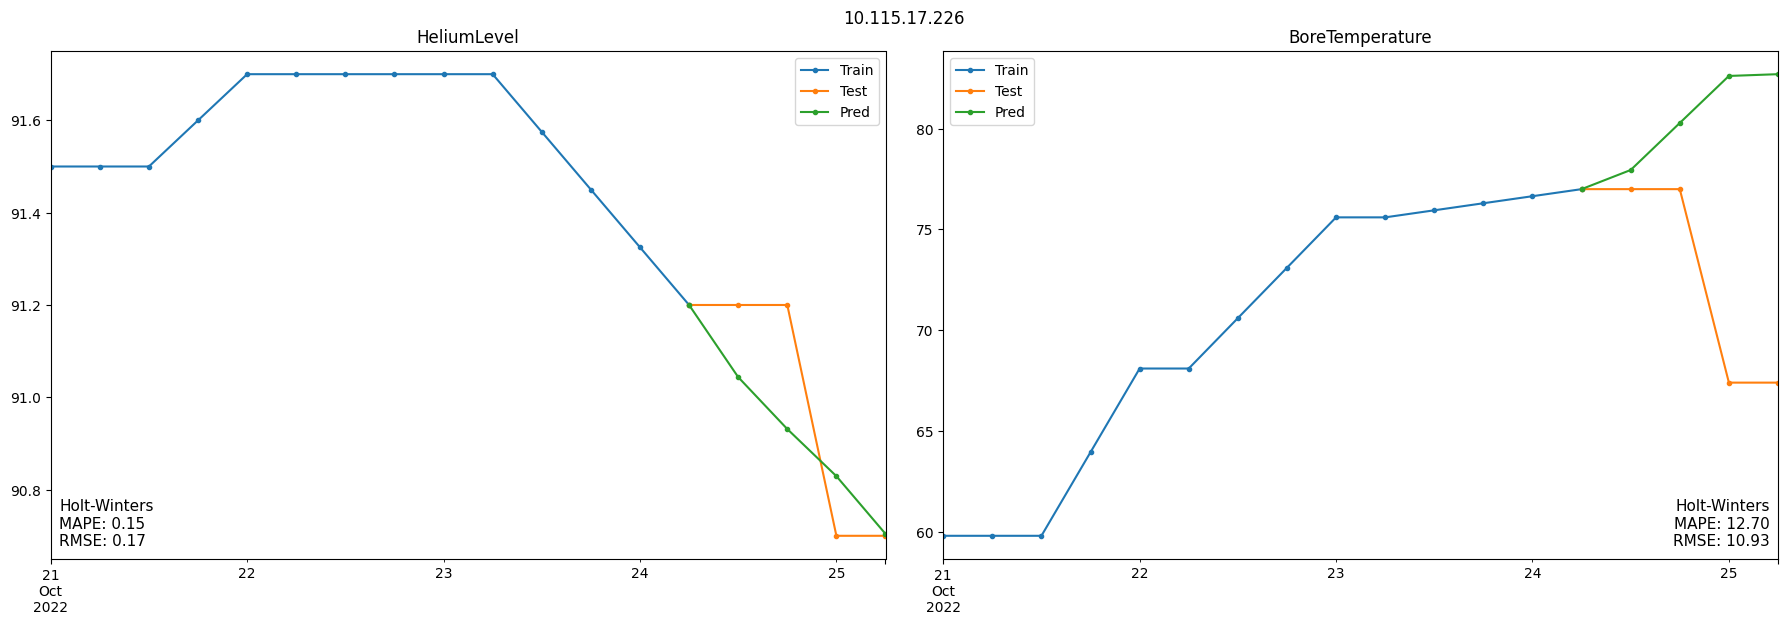

In [17]:
helium_hw_model = ExponentialSmoothing(
    endog=(df_train[measures[0]]),
    trend='add',  # From EDA
    seasonal="add",  # From EDA
    seasonal_periods=4  # A day
).fit()
helium_hw_predictions = helium_hw_model.forecast(4)
helium_hw_metrics = (
    mape(df_test[measures[0]], helium_hw_predictions),  # MAPE
    np.sqrt(mse(df_test[measures[0]], helium_hw_predictions))  #RMSE
)

bore_hw_model = ExponentialSmoothing(
    endog=(df_train[measures[1]]),
    trend='add',
    seasonal="add",
    seasonal_periods=4
).fit()
bore_hw_predictions = bore_hw_model.forecast(4)
bore_hw_metrics = (
    mape(df_test[measures[1]], bore_hw_predictions),
    np.sqrt(mse(df_test[measures[1]], bore_hw_predictions))
)
plot_predictions(
    ip=ip, 
    df_train=df_train, 
    df_test=df_test, 
    model="Holt-Winters", 
    measures=measures, 
    helium_predictions=helium_hw_predictions, 
    helium_metrics=helium_hw_metrics,
    bore_predictions=bore_hw_predictions, 
    bore_metrics=bore_hw_metrics,
)

#### 4.2 AutoARIMA

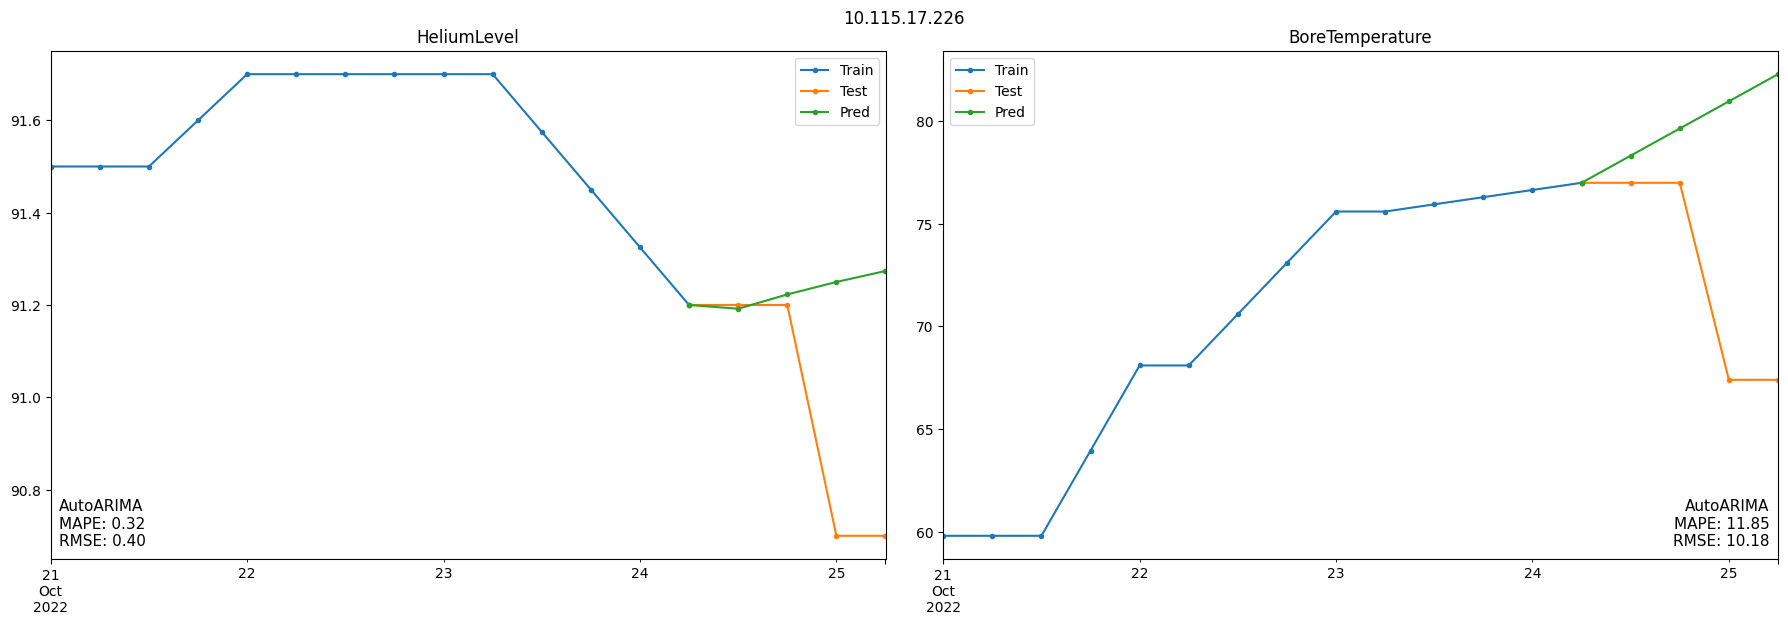

In [18]:
helium_arima_predictions = auto_arima(
    y=df_train[measures[0]],
    start_p=1, 
    start_q=1,
    max_p=3, 
    max_q=3,
    max_d=3,
    stepwise=True
).fit_predict(y=df_train[measures[0]], n_periods=4)
helium_arima_metrics = (
    mape(df_test[measures[0]], helium_arima_predictions),
    np.sqrt(mse(df_test[measures[0]], helium_arima_predictions))
)

bore_arima_predictions = auto_arima(
    y=df_train[measures[1]],
    start_p=1, 
    start_q=1,
    max_p=3, 
    max_q=3,
    max_d=3,
    stepwise=True
).fit_predict(y=df_train[measures[1]], n_periods=4)
bore_arima_metrics = (
    mape(df_test[measures[1]], bore_arima_predictions),
    np.sqrt(mse(df_test[measures[1]], bore_arima_predictions))
)

plot_predictions(
    ip=ip, 
    df_train=df_train, 
    df_test=df_test, 
    model="AutoARIMA", 
    measures=measures, 
    helium_predictions=helium_arima_predictions, 
    helium_metrics=helium_arima_metrics,
    bore_predictions=bore_arima_predictions, 
    bore_metrics=bore_arima_metrics,
)

#### 4.2 Rede Neural Recorrente

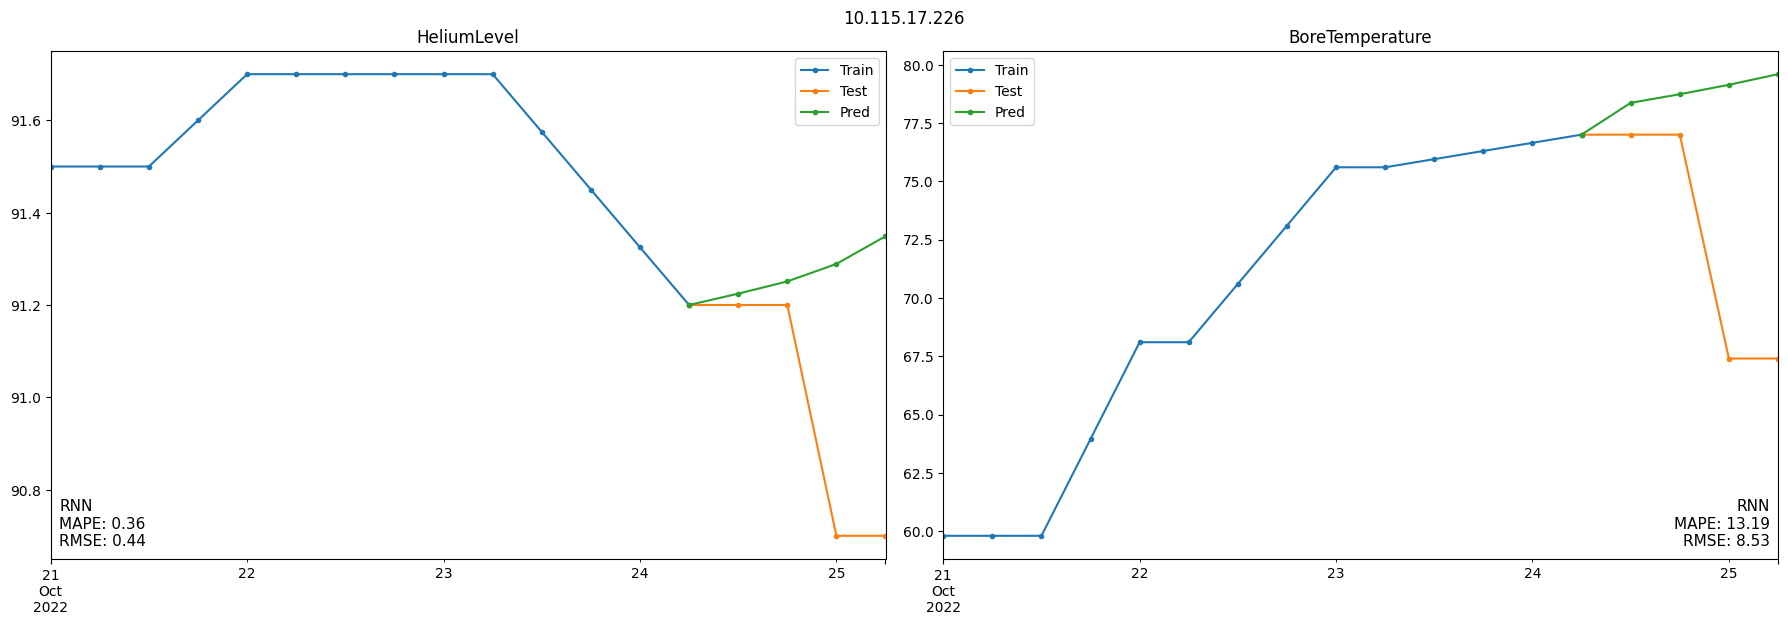

In [19]:
# Univariate with 4 periods/day
n_input, n_features = 4, 1

# Helium
helium_scaler = MinMaxScaler()
helium_scaler.fit(pd.DataFrame(df_train[measures[0]]))
df_helium_train_scaled = helium_scaler.transform(pd.DataFrame(df_train[measures[0]]))
df_helium_test_scaled = helium_scaler.transform(pd.DataFrame(df_test[measures[0]]))

# Generating Time Series from data
helium_generator = TimeseriesGenerator(
    data=df_helium_train_scaled, 
    targets=df_helium_train_scaled, 
    length=n_input,
    batch_size=1
)

helium_rnn_model = Sequential([
    LSTM(
        units=100,
        activation="relu",
        input_shape=(n_input, n_features)
    ),
    Dense(units=1),
])
helium_rnn_model.compile(
    optimizer='adam', 
    loss='mse'
)
helium_rnn_model.fit(
    x=helium_generator, 
    epochs=100,
    verbose=0,
    callbacks=[EarlyStopping(monitor="loss", min_delta=0.001, patience=10)]
)

# Getting predictions
helium_rnn_predictions = list()
batch = df_helium_train_scaled[-n_input:].reshape((1, n_input, n_features))
for value_to_predict in range(len(df_helium_test_scaled)):
    prediction = helium_rnn_model.predict(x=batch, verbose=0)[0]
    helium_rnn_predictions.append(prediction)
    batch = np.append(batch[:,1:,:], [[prediction]], axis=1)
helium_rnn_predictions = helium_scaler.inverse_transform(helium_rnn_predictions)
helium_rnn_predictions = pd.Series(helium_rnn_predictions.reshape(-1))
helium_rnn_predictions.index = df_test.index
helium_rnn_metrics = (
    mape(df_test[measures[0]], helium_rnn_predictions),
    np.sqrt(mse(df_test[measures[0]], helium_rnn_predictions))
)

# Bore
bore_scaler = MinMaxScaler()
bore_scaler.fit(pd.DataFrame(df_train[measures[1]]))
df_bore_train_scaled = bore_scaler.transform(pd.DataFrame(df_train[measures[1]]))
df_bore_test_scaled = bore_scaler.transform(pd.DataFrame(df_test[measures[1]]))


bore_generator = TimeseriesGenerator(
    data=df_bore_train_scaled, 
    targets=df_bore_train_scaled, 
    length=n_input,
    batch_size=1
)

bore_rnn_model = Sequential([
    LSTM(
        units=100,
        activation="relu",
        input_shape=(n_input, n_features)
    ),
    Dense(units=1),
])
bore_rnn_model.compile(
    optimizer='adam', 
    loss='mse'
)
bore_rnn_model.fit(
    x=bore_generator, 
    epochs=100,
    verbose=0,
    callbacks=[EarlyStopping(monitor="loss", min_delta=0.001, patience=10)]
)
bore_rnn_predictions = list()
batch = df_bore_train_scaled[-n_input:].reshape((1, n_input, n_features))
for value_to_predict in range(len(df_bore_test_scaled)):
    prediction = bore_rnn_model.predict(x=batch, verbose=0)[0]
    bore_rnn_predictions.append(prediction)
    batch = np.append(batch[:,1:,:], [[prediction]], axis=1)
bore_rnn_predictions = bore_scaler.inverse_transform(bore_rnn_predictions)
bore_rnn_predictions = pd.Series(bore_rnn_predictions.reshape(-1))
bore_rnn_predictions.index = df_test.index
bore_rnn_metrics = (
    mape(df_test[measures[0]], bore_rnn_predictions),
    np.sqrt(mse(df_test[measures[1]], bore_rnn_predictions))
)

plot_predictions(
    ip=ip, 
    df_train=df_train, 
    df_test=df_test, 
    model="RNN", 
    measures=measures, 
    helium_predictions=helium_rnn_predictions, 
    helium_metrics=helium_rnn_metrics,
    bore_predictions=bore_rnn_predictions, 
    bore_metrics=bore_rnn_metrics,
)

# 5. Salvando o modelo

O modelo de melhor performance (e também o mais simples) foi o Holt-Winters. Retreinando-o em todos os dados e serializando na pasta /models.

In [22]:
# Helium HW
helium_hw_model = ExponentialSmoothing(
    endog=(df[measures[0]]),
    trend='add',
    seasonal="add",
    seasonal_periods=4
).fit()
dump(helium_hw_model, models_folder/f"{ip}_helium_model")

# Bore RNN
bore_scaler = MinMaxScaler()
bore_scaler.fit(pd.DataFrame(df[measures[1]]))
df_bore_scaled = bore_scaler.transform(pd.DataFrame(df[measures[1]]))
bore_generator = TimeseriesGenerator(
    data=df_bore_scaled, 
    targets=df_bore_scaled, 
    length=n_input,
    batch_size=1
)
helium_rnn_model.fit(
    x=bore_generator, 
    epochs=100,
    verbose=0,
    callbacks=[EarlyStopping(monitor="loss", min_delta=0.001, patience=10)]
)
bore_rnn_model.save(models_folder/f"{ip}_bore_model")

INFO:tensorflow:Assets written to: /Users/ewerthon/Documents/Materiais/[Recursos] Ciência de Dados/time-series-sensor/models/10.115.17.226_bore_model/assets
